In [69]:
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import MultiprocessingEvaluator, ema_logging

In [70]:
used_problem_formulation = 2
dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)
#Not sure if this is necessary to have?

#for out in dike_model.outcomes:
    #print(repr(out))

In [71]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000 #In assignment 5 is at first 1000 used and later on for the dimensional stacking 10000. 
n_policies = 8 #Not sure if we have to go for 8 again here like in the earlier exploratory modeling

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [58:44<00:00,  2.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [72]:
experiments, outcomes = results

In [73]:
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

In [87]:
import numpy as np

data = outcomes['Expected Number of Deaths']

y = data < np.percentile(data, 95) #Not sure which percentile we need to use

#threshold (float) – the density threshold that a box has to meet
#Not sure which tresholds we need to use?
prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8, peel_alpha=0.05) 
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 8000 points remaining, containing 7600 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6755, coverage: 0.7110526315789474, density: 1.0 restricted_dimensions: 5


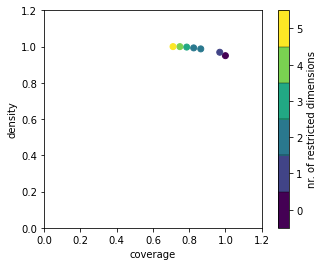

In [85]:
box1.show_tradeoff()
plt.show()

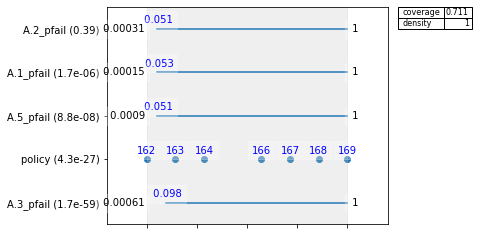

In [88]:
box1.inspect(style='graph')
plt.show()

In [89]:
from ema_workbench.analysis import dimensional_stacking

[MainProcess/INFO] model dropped from analysis because only a single category


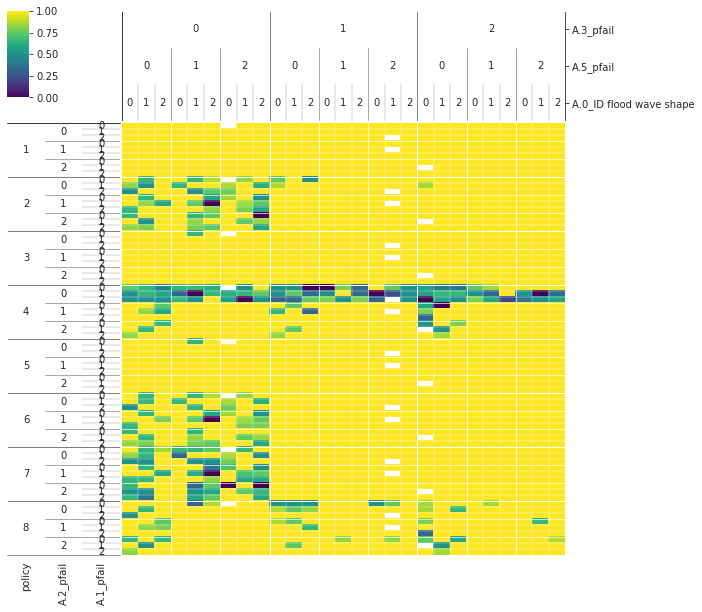

In [90]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()